In [1]:
import pandas as pd
import numpy as np

# Load expression data
expression_data = pd.read_csv('ERP009868.tsv', sep='\t', index_col=0)
# Load metadata
metadata = pd.read_csv('metadata_ERP009868.tsv', sep='\t')
gene_variances = expression_data.var(axis=0)
top_5000_genes = gene_variances.nlargest(5000).index
subset_data = expression_data[top_5000_genes]

In [2]:
from sklearn.cluster import AffinityPropagation

# Adjust damping to help with convergence, and increase max_iter
clustering_model = AffinityPropagation(damping=0.9, max_iter=1000)
clusters = clustering_model.fit_predict(subset_data.T)

# Store the cluster results in the metadata
metadata['clusters'] = clusters

# Save the updated metadata to a file
metadata.to_csv('updated_metadata_ERP009868.tsv', sep='\t')

# Check the new cluster results
print(metadata.head())


  refinebio_accession_code experiment_accession  refinebio_age  \
0               ERR1046065            ERP009868            NaN   
1               ERR1046066            ERP009868            NaN   
2               ERR1046067            ERP009868            NaN   
3               ERR1046068            ERP009868            NaN   
4               ERR1046069            ERP009868            NaN   

   refinebio_cell_line  refinebio_compound  refinebio_developmental_stage  \
0                  NaN                 NaN                            NaN   
1                  NaN                 NaN                            NaN   
2                  NaN                 NaN                            NaN   
3                  NaN                 NaN                            NaN   
4                  NaN                 NaN                            NaN   

   refinebio_disease  refinebio_disease_stage  refinebio_genetic_information  \
0                NaN                      NaN               

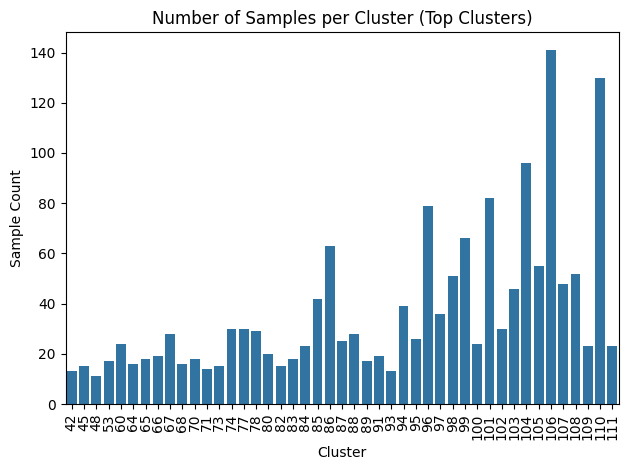

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the metadata to show only clusters with more than 10 samples (for example)
top_clusters = metadata['clusters'].value_counts()[metadata['clusters'].value_counts() > 10].index

# Plot only the top clusters
sns.countplot(x='clusters', data=metadata[metadata['clusters'].isin(top_clusters)])
plt.title('Number of Samples per Cluster (Top Clusters)')
plt.xlabel('Cluster')
plt.ylabel('Sample Count')

# Rotate x-axis labels
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


In [4]:
from sklearn.cluster import AffinityPropagation

# Function to subset and run clustering
def run_clustering_on_subset(expression_data, num_genes):
    # Subset the data to the top 'num_genes' most variable genes
    gene_variances = expression_data.var(axis=0)
    top_genes = gene_variances.nlargest(num_genes).index
    subset_data = expression_data[top_genes].T  # Transpose to have samples as rows
    
    # Run affinity propagation on the subset
    clustering_model = AffinityPropagation(damping=0.9, max_iter=1000)
    clusters = clustering_model.fit_predict(subset_data)
    
    return clusters

# Subset the data for 10, 100, 1000, and 10,000 genes and run clustering
clusters_10 = run_clustering_on_subset(expression_data, 10)
clusters_100 = run_clustering_on_subset(expression_data, 100)
clusters_1000 = run_clustering_on_subset(expression_data, 1000)
clusters_10000 = run_clustering_on_subset(expression_data, 10000)


In [4]:
import plotly.graph_objects as go

# Create a Sankey diagram showing the shifts in cluster assignments
def create_sankey(clusters_list, labels_list):
    # Build the source, target, and value lists for the Sankey diagram
    source = []
    target = []
    value = []
    
    for i in range(len(clusters_list) - 1):
        for j in range(len(clusters_list[i])):
            source.append(clusters_list[i][j])
            target.append(clusters_list[i+1][j])
            value.append(1)  # Set value to 1 per sample for now
    
    # Create the Sankey plot
    fig = go.Figure(go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=labels_list
        ),
        link=dict(
            source=source,
            target=target,
            value=value
        )
    ))

    fig.update_layout(title_text="Sankey Diagram of Cluster Membership", font_size=10)
    fig.show()

# Example cluster assignments for 10 samples across four clustering methods
clusters_10 = [0, 1, 0, 1, 2, 0, 1, 2, 1, 0]
clusters_100 = [1, 0, 2, 1, 1, 0, 1, 2, 0, 1]
clusters_1000 = [2, 1, 0, 2, 1, 0, 2, 1, 0, 1]
clusters_10000 = [0, 2, 1, 0, 2, 1, 0, 1, 2, 0]

# Labels for the clusters
labels_list = ["Cluster 0", "Cluster 1", "Cluster 2"]

# Generate the Sankey diagram
create_sankey([clusters_10, clusters_100, clusters_1000, clusters_10000], labels_list)


In [6]:
from sklearn.cluster import AffinityPropagation
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2_contingency
import pandas as pd
from statsmodels.stats.multitest import multipletests

# Assuming `expression_data` contains the gene expression data for all samples
scaler = StandardScaler()
expression_scaled = scaler.fit_transform(expression_data.T)

# Function to map mutation status
def create_mutation_status(sample_ids):
    mutation_status = []
    for sample in sample_ids:
        if isinstance(sample, str) and sample.startswith("ERR"):
            numeric_part = ''.join(filter(str.isdigit, sample[3:]))
            if numeric_part and int(numeric_part) < 1046070:
                mutation_status.append("mutated")
            else:
                mutation_status.append("non-mutated")
        else:
            mutation_status.append("non-mutated")
    return mutation_status

# Define the clustering function (for 10, 100, 1000, and 10000 genes)
def perform_affinity_propagation(n_genes):
    # Get the top n_genes most variable genes
    var_genes = expression_data.std(axis=1).sort_values(ascending=False).head(n_genes).index
    expression_subset = expression_data.loc[var_genes]
    
    # Scale the data
    scaler = StandardScaler()
    expression_scaled = scaler.fit_transform(expression_subset.T)
    
    # Run Affinity Propagation
    affinity = AffinityPropagation(random_state=42)
    clusters = affinity.fit_predict(expression_scaled)
    
    return clusters

# Generate clusters for 10, 100, 1000, and 10000 genes
clusters_10_full = perform_affinity_propagation(10)
clusters_100_full = perform_affinity_propagation(100)
clusters_1000_full = perform_affinity_propagation(1000)
clusters_10000_full = perform_affinity_propagation(10000)  # Define clusters_10000_full here

# Function to run chi-squared test
def run_chi_squared_test(clusters, sample_groups):
    if len(clusters) != len(sample_groups):
        raise ValueError(f"Length of clusters ({len(clusters)}) does not match length of sample groups ({len(sample_groups)}).")
    
    contingency_table = pd.crosstab(clusters, sample_groups)
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    return chi2, p, dof

# Explicitly cast 'refinebio_disease' to string to handle missing values properly
metadata['refinebio_disease'] = metadata['refinebio_disease'].astype(str)
metadata['refinebio_disease'] = metadata['refinebio_disease'].fillna('unknown')

# Run chi-squared tests for each clustering result
chi2_10, p_10, dof_10 = run_chi_squared_test(clusters_10_full, metadata['refinebio_disease'])
chi2_100, p_100, dof_100 = run_chi_squared_test(clusters_100_full, metadata['refinebio_disease'])
chi2_1000, p_1000, dof_1000 = run_chi_squared_test(clusters_1000_full, metadata['refinebio_disease'])
chi2_10000, p_10000, dof_10000 = run_chi_squared_test(clusters_10000_full, metadata['refinebio_disease'])

# Adjust p-values for multiple hypothesis testing (False Discovery Rate)
p_values = [p_10, p_100, p_1000, p_10000]
adjusted_p_values = multipletests(p_values, method='fdr_bh')[1]

# Output the results
results = pd.DataFrame({
    'Test': ['Affinity Propagation (10 genes)', 'Affinity Propagation (100 genes)', 
             'Affinity Propagation (1000 genes)', 'Affinity Propagation (10000 genes)'],
    'Chi-Square Statistic': [chi2_10, chi2_100, chi2_1000, chi2_10000],
    'P-value': [p_10, p_100, p_1000, p_10000],
    'Degrees of Freedom': [dof_10, dof_100, dof_1000, dof_10000],
    'Adjusted P-value (FDR)': adjusted_p_values
})

# Print the formatted results as a table
print("\nChi-squared Test Results:")
print(results.to_string(index=False))


/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:142: ConvergenceWarning:

Affinity propagation did not converge, this model may return degenerate cluster centers and labels.

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:142: ConvergenceWarning:

Affinity propagation did not converge, this model may return degenerate cluster centers and labels.

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:142: ConvergenceWarning:

Affinity propagation did not converge, this model may return degenerate cluster centers and labels.




Chi-squared Test Results:
                              Test  Chi-Square Statistic  P-value  Degrees of Freedom  Adjusted P-value (FDR)
   Affinity Propagation (10 genes)                   0.0      1.0                   0                     1.0
  Affinity Propagation (100 genes)                   0.0      1.0                   0                     1.0
 Affinity Propagation (1000 genes)                   0.0      1.0                   0                     1.0
Affinity Propagation (10000 genes)                   0.0      1.0                   0                     1.0


In [7]:
import pandas as pd

# Assuming 'metadata' contains the cluster results and sample groups
# Cluster assignment from affinity propagation (or other methods)
clusters_affinity = metadata['clusters']

# Sample groups from Assignment 1 (for example, 'refinebio_disease')
sample_groups = metadata['refinebio_disease']  # Replace with the correct column if needed

# Create the annotations DataFrame
annotations = pd.DataFrame({
    'Clusters_Affinity': clusters_affinity,
    'Sample_Groups': sample_groups
})


/opt/homebrew/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/var/folders/p8/481lnyjd7sl2v9xlhjp0gbzr0000gn/T/ipykernel_23241/2570218879.py:114: UserWarning:

Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.



<Figure size 1500x1000 with 0 Axes>

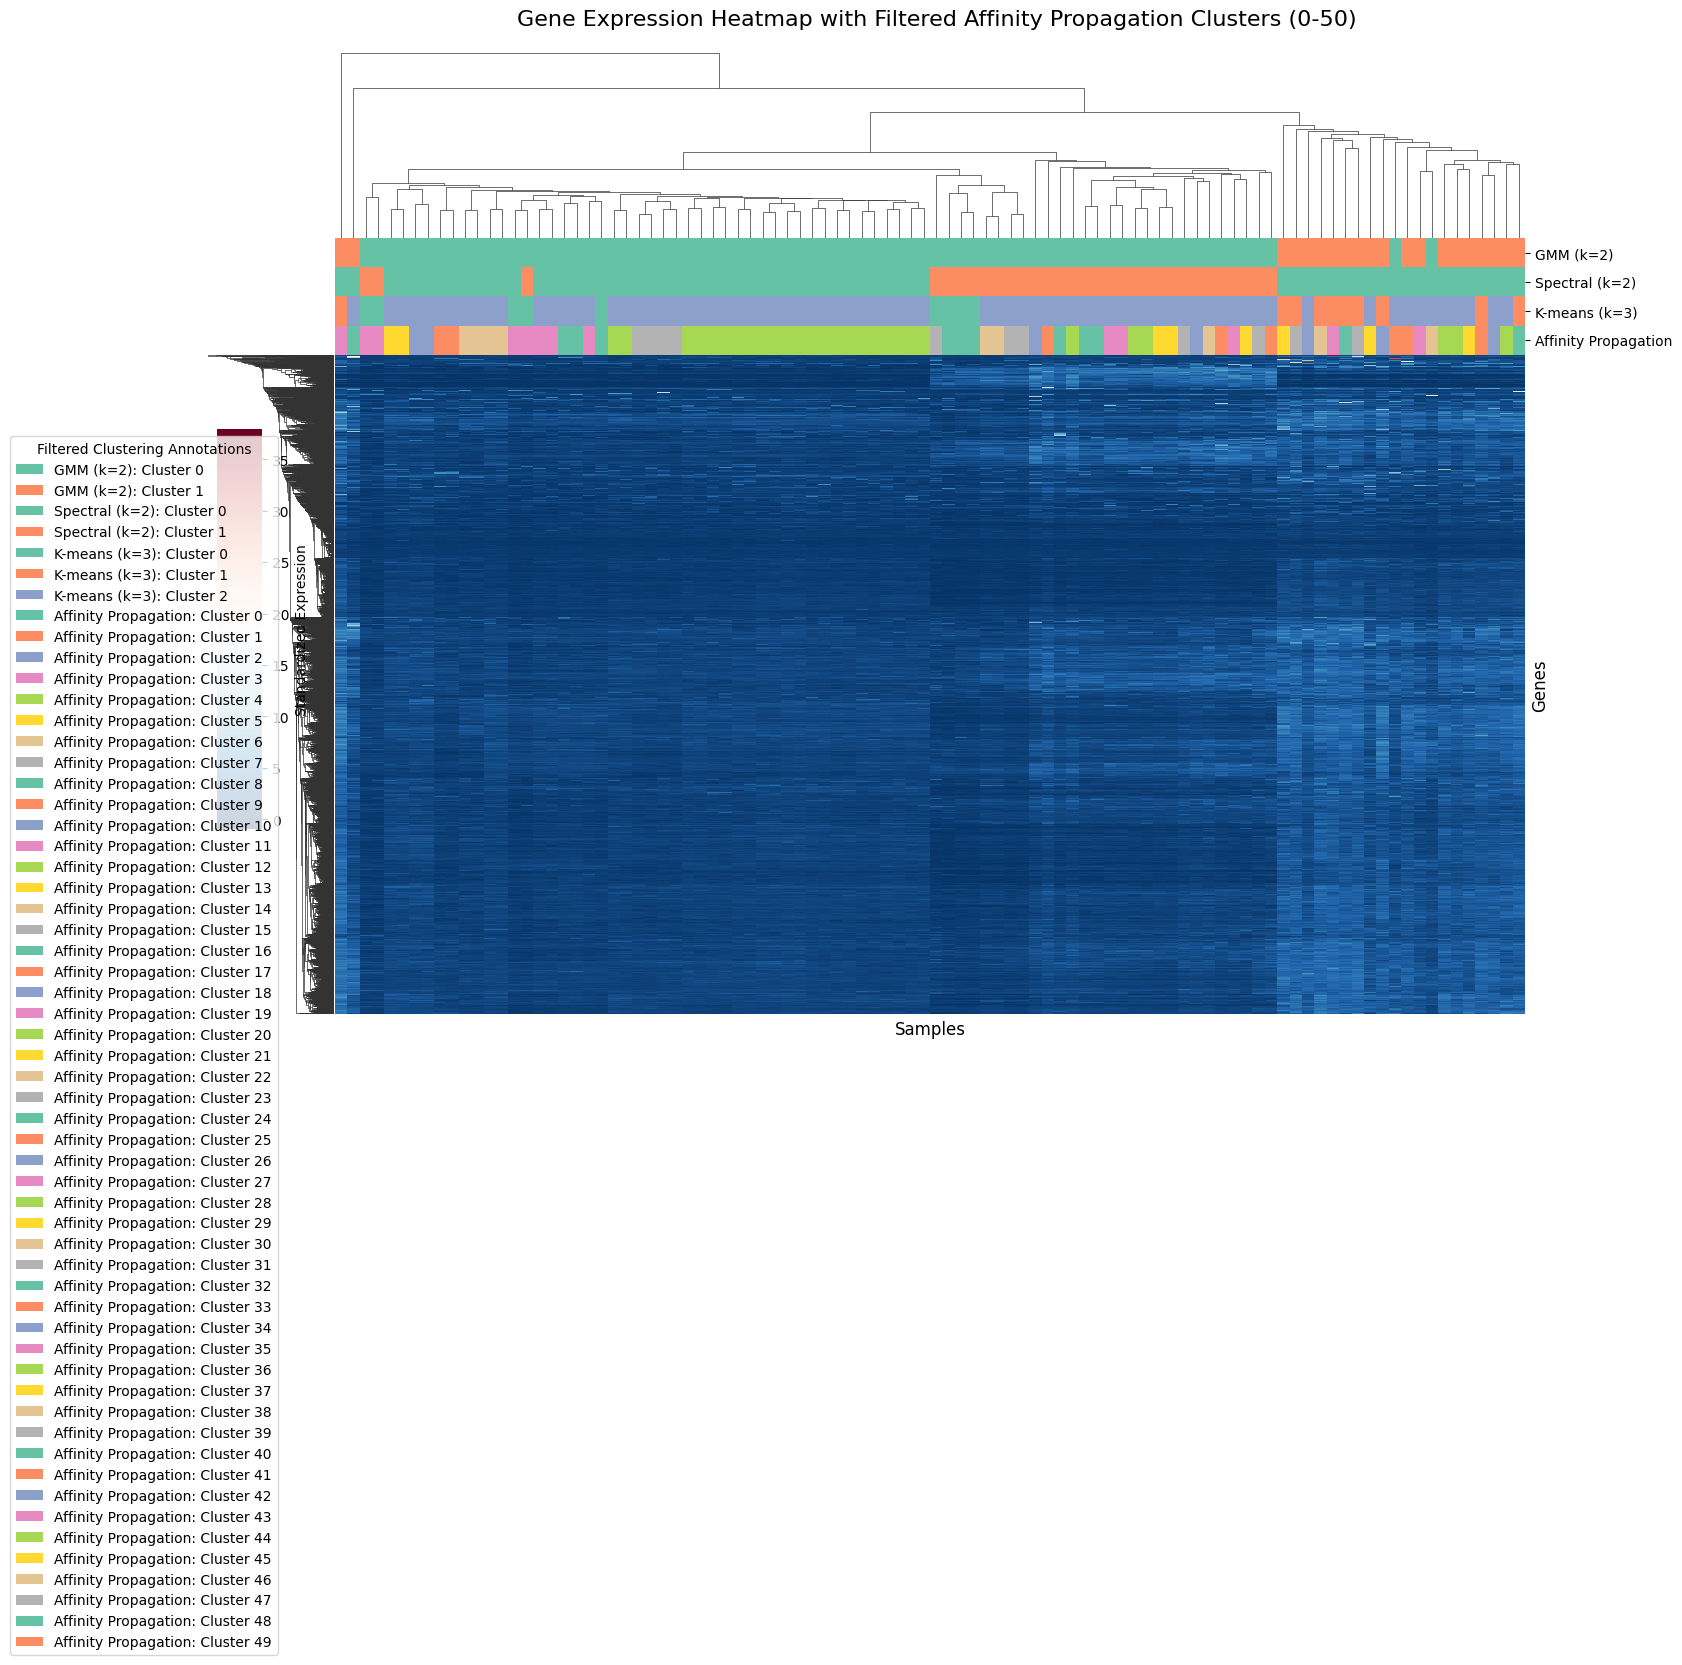

In [14]:
# Import required libraries
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation

# Assuming 'expression_data' contains your gene expression data
# Get the 5,000 most variable genes
var_genes = expression_data.std(axis=1).sort_values(ascending=False).head(5000).index
expression_subset = expression_data.loc[var_genes]

# Scale the data for better visualization
scaler = StandardScaler()
expression_scaled = pd.DataFrame(
    scaler.fit_transform(expression_subset.T).T,  # Scale the data
    index=expression_subset.index,
    columns=expression_subset.columns
)

# Create annotation DataFrame
annotations = pd.DataFrame(index=expression_subset.columns)

# Add GMM clustering results (2 clusters)
gmm = GaussianMixture(n_components=2, random_state=42)
gmm_labels = gmm.fit_predict(expression_scaled.T)
annotations['GMM (k=2)'] = gmm_labels

# Add Spectral Clustering (5 clusters)
spectral = SpectralClustering(n_clusters=5, affinity='nearest_neighbors', random_state=42)
spectral_labels = spectral.fit_predict(expression_scaled.T)
annotations['Spectral (k=2)'] = spectral_labels

# Add K-means clustering results (e.g., 3 clusters)
kmeans = KMeans(n_clusters=3, random_state=42)  # Adjust n_clusters as needed
kmeans_labels = kmeans.fit_predict(expression_scaled.T)
annotations['K-means (k=3)'] = kmeans_labels  # Add K-means labels to annotations

# Add Affinity Propagation Clustering (Dimitri's method)
affinity = AffinityPropagation(damping=0.9, random_state=42)  # Adjust preference for fewer clusters
affinity_labels = affinity.fit_predict(expression_scaled.T)
annotations['Affinity Propagation'] = affinity_labels

# Filter the Affinity Propagation clusters to only include clusters 0-50
affinity_labels_filtered = affinity_labels[affinity_labels < 50]  # Keep clusters from 0 to 49
filtered_samples = expression_scaled.columns[affinity_labels < 50]  # Filter the corresponding samples

# Create a new annotations DataFrame for the filtered samples
annotations_filtered = annotations.loc[filtered_samples]

# Create a color mapping for the clusters
cluster_colors = sns.color_palette("Set2", n_colors=3)  # We can use up to 3 colors
annotation_colors = {}

for column in annotations_filtered.columns:
    unique_values = sorted(annotations_filtered[column].unique())
    annotation_colors[column] = dict(zip(unique_values, sns.color_palette("Set2", len(unique_values))))

# Create the colors for the annotations (row colors for heatmap)
col_colors_filtered = annotations_filtered.apply(lambda x: x.map(annotation_colors[x.name]))

# Rebuild the heatmap using the filtered data and remove extra lines for a cleaner plot
plt.figure(figsize=(15, 10))
clustermap_filtered = sns.clustermap(
    expression_scaled[filtered_samples],  # Use only the filtered samples
    cmap='RdBu_r',  # Red-Blue color map
    col_colors=col_colors_filtered,  # Use the filtered annotations
    dendrogram_ratio=(.1, .2),  # Adjust size of the dendrograms
    cbar_pos=(0.02, .2, .03, .4),  # Color bar position
    row_cluster=True,  # Cluster rows (genes)
    col_cluster=True,  # Cluster columns (samples)
    xticklabels=False,  # Don't show sample labels on heatmap
    yticklabels=False,  # Don't show gene labels
    figsize=(15, 10),  # Set figure size
    linewidths=0  # Remove the lines within the heatmap cells
)

# Remove the axes borders for a cleaner look
clustermap_filtered.ax_heatmap.spines[:].set_visible(False)

# Remove the axis ticks
clustermap_filtered.ax_heatmap.set_xticks([])
clustermap_filtered.ax_heatmap.set_yticks([])

# Add titles and labels
plt.suptitle('Gene Expression Heatmap with Filtered Affinity Propagation Clusters (0-50)', y=1.02, size=16)
clustermap_filtered.ax_heatmap.set_xlabel('Samples', size=12)
clustermap_filtered.ax_heatmap.set_ylabel('Genes', size=12)

# Adjust colorbar label
clustermap_filtered.ax_cbar.set_ylabel('Standardized Expression', size=10)

# Create a custom legend for filtered annotations
legend_elements_filtered = []
for column in annotations_filtered.columns:
    unique_values = sorted(annotations_filtered[column].unique())
    for value in unique_values:
        legend_elements_filtered.append(
            plt.Rectangle((0, 0), 1, 1, 
                          fc=annotation_colors[column][value],
                          label=f'{column}: Cluster {value}')
        )

# Add filtered legend
plt.legend(handles=legend_elements_filtered, 
           title='Filtered Clustering Annotations',
           bbox_to_anchor=(1.5, 1),
           loc='upper right')

# Apply tight layout for the plot
plt.tight_layout()
plt.show()



Contingency Table for Affinity Propagation:
Affinity Propagation  0    1    2    3    4    5    6    7    8    9    ...  \
Mutation Status                                                         ...   
mutated                 1    1    1    1    1    0    0    0    0    0  ...   
non-mutated             0    0    0    0    0    1    1    1    1   20  ...   

Affinity Propagation  250  251  252  253  254  255  256  257  258  259  
Mutation Status                                                         
mutated                 4   47    9   27   14    4   34   69    4   30  
non-mutated             0    0    0    0    0    0    0    0    0    0  

[2 rows x 260 columns]

Chi-squared Test Results:
                                   Test  Chi-Square Statistic       P-value  Degrees of Freedom  Adjusted P-value (FDR)
Affinity Propagation vs Mutation Status           1844.214601 8.557733e-237                 259           8.557733e-237


/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:142: ConvergenceWarning:

Affinity propagation did not converge, this model may return degenerate cluster centers and labels.



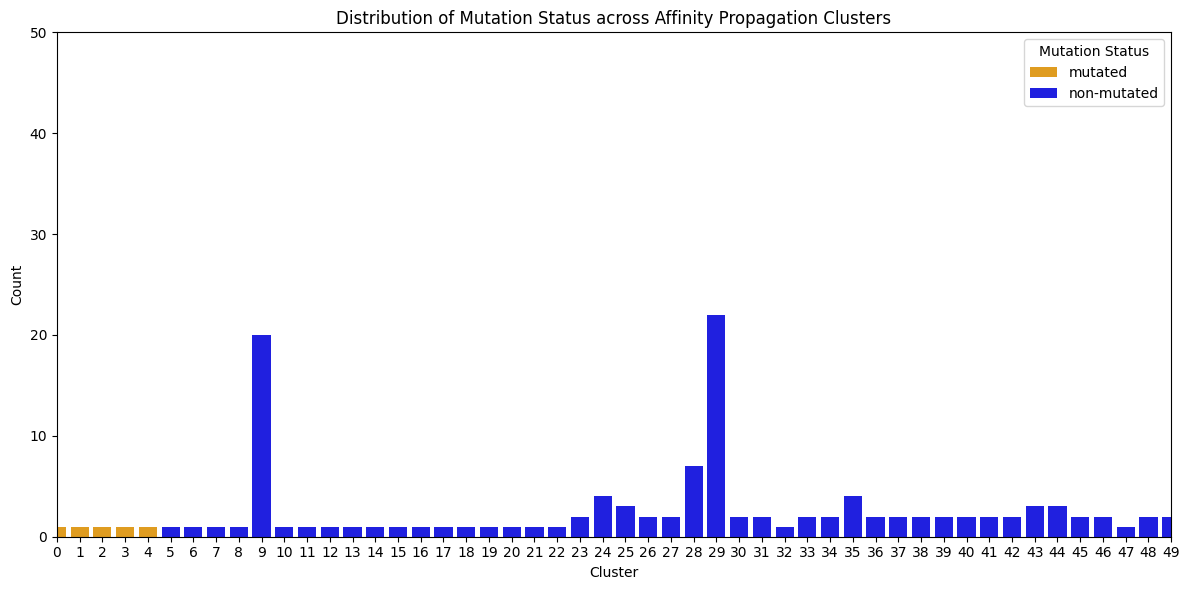

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import AffinityPropagation
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2_contingency
from statsmodels.stats.multitest import multipletests

# Function to map mutation status
def create_mutation_status(sample_ids):
    mutation_status = []
    for sample in sample_ids:
        if isinstance(sample, str) and sample.startswith("ERR"):
            numeric_part = ''.join(filter(str.isdigit, sample[3:]))
            if numeric_part and int(numeric_part) < 1046070:
                mutation_status.append("mutated")
            else:
                mutation_status.append("non-mutated")
        else:
            mutation_status.append("non-mutated")
    return mutation_status

# Function to run chi-squared test on Affinity Propagation clustering results
def perform_affinity_propagation_tests(expression_data):
    # Create mutation status
    mutation_status = create_mutation_status(expression_data.columns)
    
    # Get the 5,000 most variable genes
    var_genes = expression_data.std(axis=1).sort_values(ascending=False).head(5000).index
    expression_subset = expression_data.loc[var_genes]
    
    # Scale the data
    scaler = StandardScaler()
    expression_scaled = scaler.fit_transform(expression_subset.T)
    
    # Run Affinity Propagation
    affinity = AffinityPropagation(random_state=42)
    affinity_labels = affinity.fit_predict(expression_scaled)

    # Create contingency table
    contingency_table = pd.crosstab(
        pd.Series(mutation_status, name='Mutation Status'),
        pd.Series(affinity_labels, name='Affinity Propagation')
    )

    # Perform chi-squared test
    chi2, pval, dof, expected = chi2_contingency(contingency_table)

    # Print contingency table and results
    print(f"\nContingency Table for Affinity Propagation:")
    print(contingency_table)
    
    # Adjust p-values for multiple testing
    results = {
        'Test': 'Affinity Propagation vs Mutation Status',
        'Chi-Square Statistic': chi2,
        'P-value': pval,
        'Degrees of Freedom': dof,
        'Adjusted P-value (FDR)': multipletests([pval], method='fdr_bh')[1][0]
    }
    
    return results, affinity_labels

# Run Affinity Propagation analysis
affinity_results, affinity_labels = perform_affinity_propagation_tests(expression_data)

# Define your results in a similar format
affinity_results_formatted = pd.DataFrame({
    'Test': ['Affinity Propagation vs Mutation Status'],
    'Chi-Square Statistic': [affinity_results['Chi-Square Statistic']],
    'P-value': [affinity_results['P-value']],
    'Degrees of Freedom': [affinity_results['Degrees of Freedom']],
    'Adjusted P-value (FDR)': [affinity_results['Adjusted P-value (FDR)']]
})

# Print the formatted results as a table
print("\nChi-squared Test Results:")
print(affinity_results_formatted.to_string(index=False))

# Filter clusters to only include clusters 0-50
filtered_labels = pd.Series(affinity_labels)
filtered_labels = filtered_labels[filtered_labels.isin(range(0, 51))]

# Visualization: Mutation status vs filtered Affinity Propagation clusters
mutation_status = pd.Series(create_mutation_status(expression_data.columns))
df_plot = pd.DataFrame({
    'Mutation Status': mutation_status[filtered_labels.index],
    'Cluster': filtered_labels
})

# Plot the distribution with swapped colors
plt.figure(figsize=(12, 6))
sns.countplot(data=df_plot, x='Cluster', hue='Mutation Status', palette=["orange", "blue"])
plt.ylim(0, 50)  # Set y-axis limit to 0-50
plt.xlim(0, 49)  # Set x-axis limit to 0-49
plt.title('Distribution of Mutation Status across Affinity Propagation Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.tight_layout()
plt.show()
